In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import random

# 设置全局随机种子
seed = 3            #3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Load your data from mydata_petals.csv
data = pd.read_csv('mydata_petals.csv')

# Extract the last column (EAB) as the target variable
EAB = data.iloc[:, -1].values

# Extract the first 10 columns as input features
input = data.iloc[:, :-1].values

# Create MinMaxScaler objects for input and EAB
scaler_in = MinMaxScaler(feature_range=(-0.5, 0.5))
scaler_out = MinMaxScaler(feature_range=(-0.99, 0.99))

# Fit and transform input data, and store the transformation matrix ps_in
p_scaled = scaler_in.fit_transform(input)
p = torch.FloatTensor(p_scaled.T)
ps_in = scaler_in.scale_

# Fit and transform EAB data, and store the transformation matrix ts_out
t_scaled = scaler_out.fit_transform(EAB.reshape(-1, 1))
t = torch.FloatTensor(t_scaled)
ts_out = scaler_out.scale_

print("Scaled Data Shapes:")
print(p_scaled.shape)
print(t_scaled.shape)

# Define the number of samples for training and testing
n_train_samples = 120
n_test_samples = 80

indices = np.random.RandomState(seed=seed).permutation(len(EAB))

# Use the shuffled indices to select the specified number of samples for training and testing
train_indices = indices[:n_train_samples]
test_indices = indices[n_train_samples:n_train_samples + n_test_samples]

# Split the data into training and test sets based on the selected indices
X_train, y_train = p_scaled[train_indices], t_scaled[train_indices]
X_test, y_test = p_scaled[test_indices], t_scaled[test_indices]

# Verify the shapes of the training and test sets
print("Training Set Shapes:")
print(X_train.shape, y_train.shape)

print("Test Set Shapes:")
print(X_test.shape, y_test.shape)


# 打印训练数据前五行
print("First 5 rows of Training Data:")
print(X_train[:5])
print("First 5 rows of Training Target (y_train):")
print(y_train[:5])

print("Test Data Shapes:")
print(X_test.shape, y_test.shape)

# 打印测试数据前五行
print("First 5 rows of Test Data:")
print(X_test[:5])
print("First 5 rows of Test Target (y_test):")
print(y_test[:5])

Scaled Data Shapes:
(2000, 10)
(2000, 1)
Training Set Shapes:
(120, 10) (120, 1)
Test Set Shapes:
(80, 10) (80, 1)
First 5 rows of Training Data:
[[-0.22072072  0.48398398  0.22472472 -0.30861723 -0.02301973  0.282
  -0.30188679 -0.48798398  0.22320917  0.10080107]
 [ 0.31381381 -0.43293293 -0.15365365  0.4238477   0.33500143 -0.5
   0.31618067  0.40186916 -0.35157593 -0.41522029]
 [ 0.13663664 -0.4029029   0.25075075 -0.24849699 -0.34958536 -0.11133333
   0.43138937  0.3518024  -0.4974212   0.12950601]
 [ 0.1016016  -0.37787788 -0.44894895  0.30360721 -0.09422362 -0.40133333
   0.26529445 -0.2129506  -0.10315186  0.29639519]
 [-0.26276276 -0.19469469 -0.3018018  -0.12224449 -0.17657993 -0.16
  -0.21126358 -0.22296395  0.32664756 -0.43457944]]
First 5 rows of Training Target (y_train):
[[ 0.5819084 ]
 [-0.15870229]
 [-0.27961832]
 [ 0.21916031]
 [ 0.2040458 ]]
Test Data Shapes:
(80, 10) (80, 1)
First 5 rows of Test Data:
[[ 0.13063063  0.27877878 -0.26376376  0.16733467  0.41649986 -0.

Training duration: 0.27 seconds


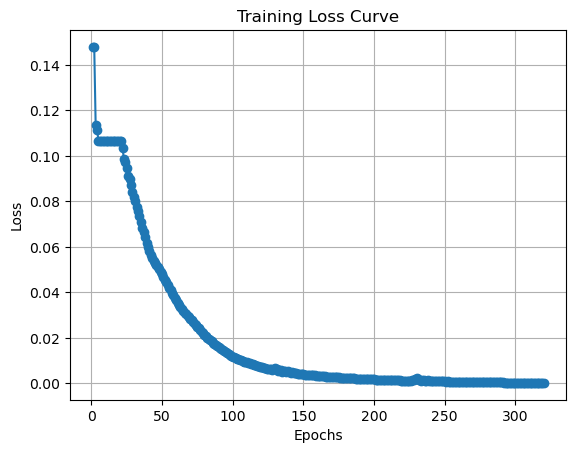

DNN(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=6, bias=True)
    (5): Tanh()
    (6): Linear(in_features=6, out_features=3, bias=True)
    (7): Tanh()
    (8): Linear(in_features=3, out_features=1, bias=True)
  )
)


In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

# 设置全局随机种子
#seed = 42
#random.seed(seed)
#np.random.seed(seed)
#torch.manual_seed(seed)

# Define your DNN architecture
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DNN, self).__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(1, len(dims)):
            self.layers.append(nn.Linear(dims[i - 1], dims[i]))
            if i < len(dims) - 1:
                self.layers.append(nn.Tanh())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Define the fitness function for GA
def fitness_function(weights, dnn, criterion, inputs, targets):
    start_idx = 0
    for param in dnn.parameters():
        param_size = param.numel()
        param.data = torch.FloatTensor(weights[start_idx:start_idx+param_size]).view(param.size())
        start_idx += param_size

    outputs = dnn(inputs)
    loss = criterion(outputs, targets)
    return loss.item()

# Hyperparameters
input_dim = 10
output_dim = 1
hidden_dims = [12, 10, 6, 3]

# Data
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

# Initialize the DNN
dnn = DNN(input_dim, output_dim, hidden_dims)
criterion = nn.MSELoss()

# Define the problem bounds for GA
num_weights = sum(p.numel() for p in dnn.parameters())
lb = [-1.0] * num_weights
ub = [1.0] * num_weights

# Initialize GA parameters
pop_size = 30
max_generations = 20
mutation_rate = 0.1
crossover_rate = 0.8

# Training parameters
external_epochs = 300
learning_rate = 0.01

# Initialize the population
population = [np.random.uniform(lb, ub) for _ in range(pop_size)]

# Record the start time
start_time = time.time()

# Main GA loop
losses = []

for generation in range(max_generations):
    fitness_scores = [fitness_function(individual, dnn, criterion, X_train, y_train) for individual in population]
    best_index = np.argmin(fitness_scores)
    best_individual = population[best_index]

    # Apply the best individual's weights to the DNN
    start_idx = 0
    for param in dnn.parameters():
        param_size = param.numel()
        param.data = torch.FloatTensor(best_individual[start_idx:start_idx+param_size]).view(param.size())
        start_idx += param_size

    losses.append(fitness_scores[best_index])

    # Select the top performers
    num_selection = int(pop_size * 0.2)
    selected_indices = np.argsort(fitness_scores)[:num_selection]
    selected_population = [population[i] for i in selected_indices]

    # Crossover
    new_population = []
    while len(new_population) < pop_size:
        parent1 = random.choice(selected_population)
        parent2 = random.choice(selected_population)
        if random.random() < crossover_rate:
            crossover_point = random.randint(0, num_weights)
            child = list(parent1[:crossover_point]) + list(parent2[crossover_point:])
            new_population.append(child)

    # Mutate
    for i in range(pop_size):
        if random.random() < mutation_rate:
            mutated_individual = np.random.uniform(lb, ub)
            new_population[i] = mutated_individual

    population = new_population

# After GA, continue training with optimized weights
best_individual = population[best_index]  # Use the best individual found by GA
start_idx = 0
for param in dnn.parameters():
    param_size = param.numel()
    param.data = torch.FloatTensor(best_individual[start_idx:start_idx+param_size]).view(param.size())
    start_idx += param_size    
# After GA, continue training with optimized weights
optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
for epoch in range(external_epochs):
    optimizer.zero_grad()
    outputs = dnn(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Record the end time
end_time = time.time()
# Calculate and print the training duration
training_duration = end_time - start_time
print(f"Training duration: {training_duration:.2f} seconds")
# Plot the loss curve
plt.figure()
plt.plot(range(1, max_generations + external_epochs + 1), losses, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()
print(dnn)

R-squared (r_train) on training set: 0.998
Mean Absolute Error (MAE) on training set: 0.011
Mean Squared Error (MSE) on training set: 0.000
Root Mean Squared Error (RMSE) on training set: 0.016
R-squared (r_test) on test set: 0.781
Mean Absolute Error (MAE) on test set: 0.138
Mean Squared Error (MSE) on test set: 0.030
Root Mean Squared Error (RMSE) on test set: 0.174


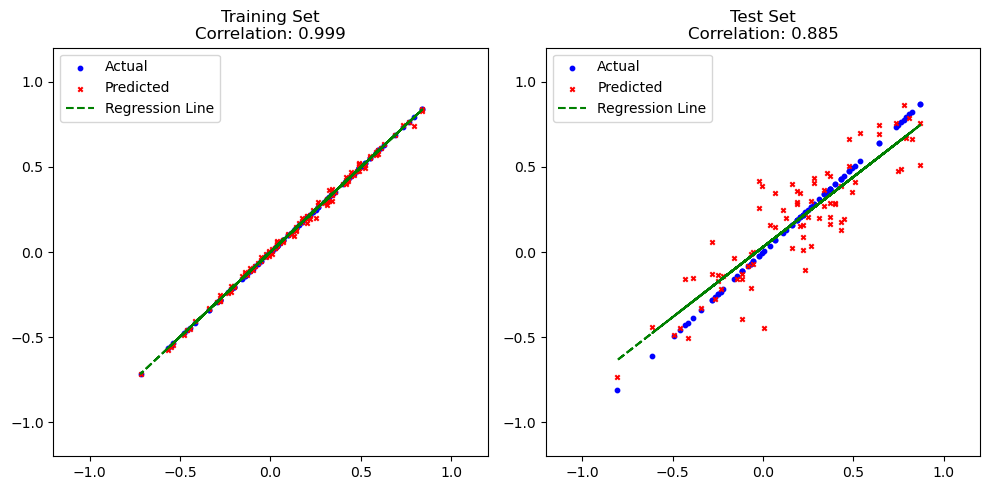

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math


with torch.no_grad():
    predicted_train = dnn(torch.FloatTensor(X_train))
    train_true_values = y_train
    r_train = r2_score(train_true_values, predicted_train)
    mae_train = mean_absolute_error(train_true_values, predicted_train)   # MAE training set
    mse_train = mean_squared_error(train_true_values, predicted_train)    # MSE training set
    rmse_train = math.sqrt(mse_train)                               # RMSE training set

print(f"R-squared (r_train) on training set: {r_train:.3f}")
print(f"Mean Absolute Error (MAE) on training set: {mae_train:.3f}")
print(f"Mean Squared Error (MSE) on training set: {mse_train:.3f}")
print(f"Root Mean Squared Error (RMSE) on training set: {rmse_train:.3f}")

with torch.no_grad():              # Perform regression analysis on the test set (X_test, y_test)
    predicted_test = dnn(torch.FloatTensor(X_test))
    test_true_values = y_test
    r_test = r2_score(test_true_values, predicted_test)
    mae_test = mean_absolute_error(test_true_values, predicted_test)   #MAE test set
    mse_test = mean_squared_error(test_true_values, predicted_test)    # MSE test set
    rmse_test = math.sqrt(mse_test)                               #RMSE test set
    predicted_train = dnn(torch.FloatTensor(X_train))

print(f"R-squared (r_test) on test set: {r_test:.3f}")
print(f"Mean Absolute Error (MAE) on test set: {mae_test:.3f}")
print(f"Mean Squared Error (MSE) on test set: {mse_test:.3f}")
print(f"Root Mean Squared Error (RMSE) on test set: {rmse_test:.3f}")
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

actual_train = y_train
actual_test = y_test  # Replace 'y_test' with your test labels

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot of actual values and regression line for training set
axes[0].scatter(actual_train, actual_train, color='blue', label='Actual', marker='o', s=10)
axes[0].scatter(actual_train, predicted_train, color='red', label='Predicted', marker='x', s=10)
axes[0].set_xlim(-1.2, 1.2)
axes[0].set_ylim(-1.2, 1.2)
correlation_train = np.corrcoef(actual_train, predicted_train, rowvar=False)[0, 1]
axes[0].set_title(f'Training Set\nCorrelation: {correlation_train:.3f}')
regression_train = LinearRegression()
regression_train.fit(actual_train.reshape(-1, 1), predicted_train)
regression_line_train = regression_train.predict(actual_train.reshape(-1, 1))
axes[0].plot(actual_train, regression_line_train, color='green', linestyle='--', label='Regression Line')
axes[0].legend()

# Scatter plot of actual values and regression line for test set
axes[1].scatter(actual_test, actual_test, color='blue', label='Actual', marker='o', s=10)
axes[1].scatter(actual_test, predicted_test, color='red', label='Predicted', marker='x', s=10)
axes[1].set_xlim(-1.2, 1.2)
axes[1].set_ylim(-1.2, 1.2)
correlation_test = np.corrcoef(actual_test, predicted_test, rowvar=False)[0, 1]
axes[1].set_title(f'Test Set\nCorrelation: {correlation_test:.3f}')
regression_test = LinearRegression()
regression_test.fit(actual_test.reshape(-1, 1), predicted_test)
regression_line_test = regression_test.predict(actual_test.reshape(-1, 1))
axes[1].plot(actual_test, regression_line_test, color='green', linestyle='--', label='Regression Line')
axes[1].legend()
plt.tight_layout()
plt.show()